# Trabalhando com Textos

No capítulo 4, estudamos features e propriedades de dados estruturados contínuos e categóricos. No entanto, podemos aplicar Machine Learning em dados não-estruturados também, como imagens, textos, vídeos e áudios. Nesse capítulo, serão apresentados conceitos iniciais de como trabalhar com textos para tasks de ML como análise de sentimentos, classificação de email etc.

Textos são geralmente representados como um grupo de strings com comprimento inderterminado. Esse tipo de dado é BEEEEEM diferente de qualquer coisa que vimos até agora e precisa ser tratada antes de aplicarmos algoritmos de ML.

## Strings

Antes de começar nos passos de preprocessing para implementação de algoritmos, vamos discutir um pouquinho sobre o que configura um texto, uma vez que não são todas as strings que devem ser tratadas como um texto.

Podemos encontrar datasets com strings em 4 formas diferentes:
* **Dado Categórico**: vem em uma lista fixada, como o UF em que uma pessao mora. Já estamos acostumados com esse tipo de dado.
* **Strings Livres que podem ser Mapeadas para Categorias**: mesma ideia de cima, só que utilizando um campo de texto para preenchimento (o que ocasiona erros gramáticos e semânticos - idealmente sempre obter dados categóricos através de menus de seleção).
* **Dados Estruturados em forma de String**: Aqui entra nomes de lugares ou pessoas, datas, identificadores e endereços. Coisas que não entram como categoria, mas normalmente são estruturados (e bem difíceis de parsear).
* **Dados de Texto**: Finalmente, dados em forma de texto. São exemplos textos complexos e completos, como a obra de Shakespeare, até frases mais simples, como tweets, logs de chat e reviews de um aplicativo.

## Exemplo de Aplicação: Análise de Sentimentos em Resenhas de Filmes

Como exemplo de aplicação e de execução durante o capítulo, vamos utilizar o dataset do IMDb coletado pelo pesquisador de Stanford Andrew Maas. O dataset está disponível em: http://ai.stanford.edu/~amaas/data/sentiment/.

Esse dataset contém o texto das reviews, em conjunto com uma label indicando se a review é positiva ou negativa (classificação binária).

In [1]:
from sklearn.datasets import load_files
import numpy as np
import pandas as pd

reviews_train = load_files("data/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

print(f"type of text_train: {type(text_train)}")
print(f"length of text_train: {len(text_train)}")
print(f"text_train[1]:\n{text_train[1]}")

type of text_train: <class 'list'>
length of text_train: 25000
text_train[1]:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisio

Como é possível ver, o dataset de treino é uma lista contendo 25 mil strings, e eu plotei a segunda review para termos uma ideia do que é o problema.

Tags HTML de quebra de linha como "\<br />\<br />" são bem comuns e vamos ter que limpa-las em todo o dataset.

In [2]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [3]:
print(f"Samples per class (training): {np.bincount(y_train)}")

Samples per class (training): [12500 12500]


Como dito anteriormente, são duas classes: comentário positivo e negativo. O dataset foi coletado de forma que não haja necessidade de estratificação dos dados, ou seja, as classes já são balanceadas em ambos os datasets.

Vamos dar load e aplicar o mesmo tratamento inicial ao set de testes:

In [4]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples per class (test): {np.bincount(y_test)}")
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


Podemos então definir a task: dado um comentário, queremos atribuir uma label "positive" ou "negative" baseado no texto que contém a review.

Para resolver, precisamos transformar o texto em uma representação numérica que podemos aplicar os algoritmos de Machine Learning:

## Representanto texto em forma de "Bag of Words"

Uma das formas mais simples mas efetiva e comumente utilizada para representar textos para algoritmos de ML é a representação *bag-of-words*.

Como dito, a ideia é simples: descartamos a estrutura, como os paragrafos e as frases e apenas contamos quantas vezes cada palavra aparece em cada texto no set. Geralmente, criar a representação bag-of-words para um set de textos toma 3 passos:
* **Tokenização**: separa cada texto em uma lista de palavras únicas (utilizando pontuação ou espaços em branco).
* **Criação do Vocabulário**: coleta o vocabulário (todas as palavras que apareceram em todos os documentos) e númera cada uma delas.
* **Encoding**: para cada documento, contar quantas vezes cada palavra no vocabulário aparece no documento.

Claro que existem alguns cuidados que devem ser tomados em cada passo, principalmente no primeiro e no segundo, mas trataremos deles mais a frente. 

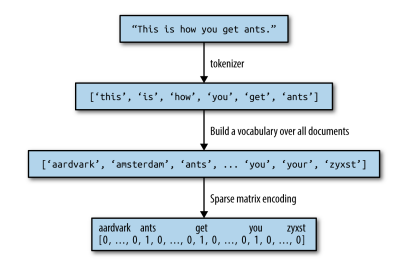

### Aplicando o Bag of Words em um dataset simples

A implementação do bag-of-words no scikit-learn é feita através do CountVectorizer, um objeto transformador (como os encoders que já vimos por aqui). Vamos observar o seu funcionamento em um dataset contendo apenas duas frases:

In [5]:
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content:\n {vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


O vocabulário consiste em 13 palavras, que vão desde o "be" até o "wise" (label em ordem alfabética). Para criar a representação bag-of-words, utilizamos o método ".transform" do transformador.

In [6]:
bag_of_words = vect.transform(bards_words)
print(f"bag_of_words: {repr(bag_of_words)}")

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


A representação fica armazenada numa matriz sparse do SciPy, que apenas utiliza memória para guardar as posições e os valores não-zero. Isso se dá pois normalmente vocabulários tem MUITAS palavras (imagine todas as palavras de um dicionário PT-BR marcadas como zero e uma frase longa, como essa que escrevo agora... quantos zeros precisariam ser utilizados?)

Ainda assim, por motivos de visualização, podemos transforma-la em uma array do numpy:

In [7]:
bag_of_words.toarray()

array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]], dtype=int64)

Como nenhuma das strings possui palavras repetidas, não vemos nenhum número acima de 1 na array. Se formos checar em ordem alfabética a array acima, verá que bate bem certinho (be, but na segunda frase, por exemplo, são os dois primeiros 1s).

### Bag-of-Words para Resenhas de Filmes

Agora que já conhecemos o processo, vamos aplicá-lo ao problema do capítulo: análise sentimental.

In [8]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train: {repr(X_train)}")

X_train: <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


Bah! A matriz sparse possui 25mil linhas e 74849 colunas... isso indica que o vocabulário está com quase 75mil palavras. Vamos olhar um pouquinho mais fundo esse objeto utilizando o get_feature_name, um método bem conveniente que retorna uma lista onde cada entrada corresponde a uma feature: 

In [9]:
feature_names = vect.get_feature_names()
print(f"Numero de features:{len(feature_names)}")
print(f"Primeiras 20 features:\n{feature_names[:20]}")
print(f"\n20010th to 20030th features:\n{feature_names[20010:20030]}")
print(f"\nA cada 2000 features:\n{feature_names[::2000]}")

Numero de features:74849
Primeiras 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']

20010th to 20030th features:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']

A cada 2000 features:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


Não dá pra dizer que não é um dataset diverso hehe! As primeiras features são apenas números e isso é até esperado - mas provavelmente **elas não tem valor semântico algum** (talvez o 007, né?).
<br>

Outra coisa, agora observando o segundo set de features, **é a separação de substantivos em suas formas plural e singular** (draught e draughts, por exemplo). O sentido semântico é muito próximo e para o modelo também deveria ser, então contar commo palavras diferentes não é ideal.
<br>

Antes de começar a limpar ainda mais esse vocabulário e realizar a extração das features de texto, vamos criar um classificador simples de Logistic Regression (até pela matriz ser bem sparse) usando validação cruzada só utilizar como baseline. 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(max_iter=2000), X_train, y_train, cv=5)
print(np.mean(scores))

0.88124


Vamos melhorar agora a extração das palavras. Por padrão, o CountVectorizer extrai tokens utilizando a RegEx "\b\w\w+\b", que basicamente significa dar match com todas as sequências de caracteres que consistem em **pelo menos 2 letras ou números** (\w) e que são **separadas por pontuações/whitespace** (\b). Pelo lado positivo, isso já omite tokens formados por letras únicas, mas também corta contrações escritas em inglês, como "doesn't". Além disso, o CountVectorizer também, por padrão, converte tudo para letra minúscula antes de começar a tokenização (soon, Soon, SoOn são iguais).
<br>

Apesar da tokenização até ser efetiva, para documentos com muito "lixo" como comentários de um site, podemos acabar com muitas features inúteis - como os números mostrados acima, por exemplo. Para resolver iso, podemos estipular um número minímo de strings que cada token deve aparecer para entrar no vocabulário.

In [11]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train c/ min_df=5: {repr(X_train)}")

X_train c/ min_df=5: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


Reduzimos o número de features para quase um terço! Vamos observar as features como fizemos da primeira vez:

In [12]:
feature_names = vect.get_feature_names()

print(f"Numero de features:{len(feature_names)}")
print(f"Primeiras 20 features:\n{feature_names[:20]}")
print(f"\n20010th to 20030th features:\n{feature_names[20010:20030]}")
print(f"\nA cada 2000 features:\n{feature_names[::2000]}")

Numero de features:27271
Primeiras 20 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']

20010th to 20030th features:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']

A cada 2000 features:
['00', 'baked', 'centipede', 'cutlery', 'elton', 'gaining', 'ideals', 'leering', 'moxy', 'picasso', 'repartee', 'silvers', 'talkative', 'verisimilitude']


Além da redução no número de números, diversas palavras bizarras/mal escritas sumiram. Ainda assim, temos o problema de palavras semânticamente iguais, mas resolveremos isso mais tarde. Vamos ver o resultado do LogisticRegression nesse dataset:

In [13]:
scores = cross_val_score(LogisticRegression(max_iter=2000), X_train, y_train, cv=5)
print(np.mean(scores))

0.8793600000000001


O modelo perdeu um pouco de acurácia (aproximadamente 0.2%), mas acabou sendo bem mais rápido para treinar devido ao menor número de features. Além disso, descartar features inúteis torna o modelo mais fácil de ser interpretado.

### Stopwords

Outra forma comum de descartar features inúteis é eliminando palavras que são MUITO frequentes para ser informativas. Conjunções, alguns advérbios de intensidade e pronomes (principalmente o de primeira pessoa, em inglês) são usados em comentários positivos e negativos de forma constante e frequente. O scikit-learn oferece uma lista com essas palavras:

In [14]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword:\n{list(ENGLISH_STOP_WORDS)[::10]}")

Number of stop words: 318
Every 10th stopword:
['wherein', 'had', 'own', 'then', 'neither', 'two', 'hence', 'fifty', 'an', 'latterly', 'somehow', 'rather', 'anyway', 'however', 'inc', 'whence', 'less', 'become', 'thence', 'due', 'elsewhere', 'myself', 'so', 'bottom', 'has', 'our', 'thereafter', 'were', 'please', 'alone', 'hers', 'hereby']


Se estivermos utilizando o CountVectorizer, podemos usar o argumento padrão que já implementará a lista:

In [15]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with stop words:\n{repr(X_train)}")

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [16]:
scores = cross_val_score(LogisticRegression(max_iter=2000), X_train, y_train, cv=5)
print(np.mean(scores))

0.87544


Novamente, perdemos um pouco de acurácia. No entanto, dessa vez o custo de score foi maior e a redução de features foi beeeem menor. Para esse problema em específico, remover as stopwords não parece ser uma ideia muito boa, uma vez que 300 features a menos de 27mil não vai melhorar muito a interpretabilidade.
<br>

### Frequência do Termo–Inverso da Frequência nos Documentos

Espero que o nome grande não assuste, porque a ideia desse processo é relativamente simples. Outra técnica para extração de features de texto é a TF-IDF, ou *term frequency-inverse document frequency*. Esse processo dá mais peso para tokens que aparecem múltiplas vezes em uma única string MAS reduz o peso deles caso ele apareça em múltiplas strings.

A motivação é simples: se um termo aparece múltiplas vezes em um único documento, ele deve ser uma feature importante para àquele documento. Caso apareça muitas vezes em vários, é apenas uma palavra comum.

A implementação através do scikit-learn é bem simples e pode ser feita de duas formas:
* **TfidfTransformer**: toma a matriz sparse produzida pelo CountVectorizer e transforma ela.
* **TfidfVectorizer**: implementa o bag-of-words e transforma.

Vale notar que caso seja utilizado GridSearch ou validação cruzada, devemos faze-lo dentro de um Pipeline, uma vez que o tf-idf utiliza propriedades estatísticas do set de treino!

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=2000))

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print(f"Best cross-validation score: {grid.best_score_}")

Best cross-validation score: 0.8938400000000002


Utilizando o tf-idf podemos verificar um pequeno aumento no score anterior. Claro, parte disso também pode ter sido causada pela escolha de um hiperparâmetro melhor.
<br>

O tf-idf também permite que verificar quais os tokens que ele achou mais importante: 

In [18]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

X_train = vectorizer.transform(text_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(vectorizer.get_feature_names())

print(f"Features with lowest tfidf:\n{feature_names[sorted_by_tfidf[:20]]}")
print(f"Features with highest tfidf: \n{feature_names[sorted_by_tfidf[-20:]]}")

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


Palavras com tfidf baixo ou são extremamente raras ou usadas muito comummente entre documentos. Uma coisa interessante que podemos ver é que entre as features com tfidf alto, estão os nomes de alguns filmes/séries/personagens. 

## Investigando os Coeficientes do LR

Vamos dar um foco maior aos coeficientes do LR e ver o que o modelo realmente aprendeu dos dados. Como são muitas features, vamos apenas olhar os coeficientes daqueles com os valores absolutos:

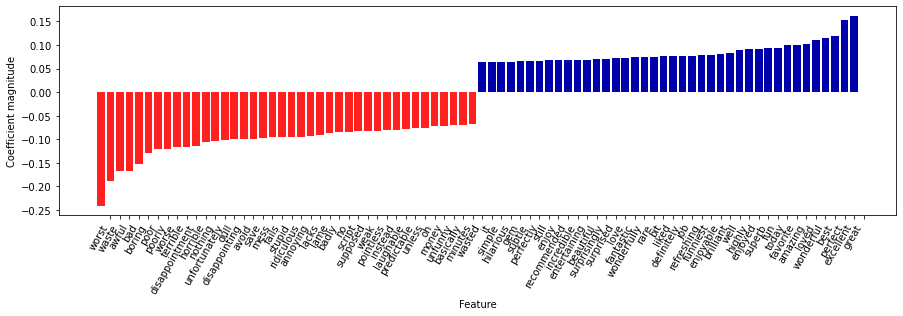

In [19]:
import mglearn

mglearn.tools.visualize_coefficients(
 grid.best_estimator_.named_steps["logisticregression"].coef_,
 feature_names, n_top_features=40)

Do lado esquerdo, estão as features que tiveram mais impacto para o modelo prever como negativo e o oposto é verdade também. Podemos ver palavras como 'worst', 'waste', 'awful' em vermleho e 'great', 'excelent' em azul.

Entre as palavras, também podemos ver algumas que não fazem tanto sentido - 'today', por exemplo. Essa palavra provavelmente é usada em conjunto com outras para fazer um elogio. Para captar múltiplas palavras/expressões, podemos usar n-Grams.

## Bag-of-Words com Mais de uma Palavra (n-Grams)

Uma das desvantagens de usar o Bag-of-Words default é que ele não pega contexto: "it's bad, not good at all" e "it's good, not bad at all" tem o MESMO valor para a representação. Para resolver isso, **utilizamos n-Grams**. Como sempre, n é a quantidade - logo bigrams são representações que pegam também conjuntos de 2 palavras, trigrams de 3 e por aí vai. 
<br>

No scikit-learn, eles são facilmente implementados nos próprios CountVectorizer e TfidfVectorizer utilizando o argumento 'ngram_range', que recebe uma tupla contendo o minímo e o máximo tamanho que um token deve ter:

In [20]:
# Olhando apenas os bigramas
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)

print(f"Vocabulary size: {len(cv.vocabulary_)}")
print(f"Vocabulary:\n{cv.get_feature_names()}")

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [21]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)

print(f"Vocabulary size: {len(cv.vocabulary_)}")
print(f"Vocabulary:\n{cv.get_feature_names()}")

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


Para a maior parte das aplicações, o minímo deve ser 1 - palavras geralmente tem muito significado sozinhas. No entanto, o máximo deve ser escolhido com cuidado, uma vez que aumentar demais pode aumentar exponencialmente o número de features e causar overfitting no modelo. 
<br>

Uma escolha interesante é utilizar o GridSearch para selecionar o número máximo de n-grams:

In [22]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=2000))

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print(f"Best cross-validation score: {grid.best_score_}")
print(f"Best parameters:\n{grid.best_params_}")

Best cross-validation score: 0.9064400000000001
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


Tivemos o melhor score até agora utilizando trigrams, 90.6% de acurácia. Vamos observar os coeficientes agora:

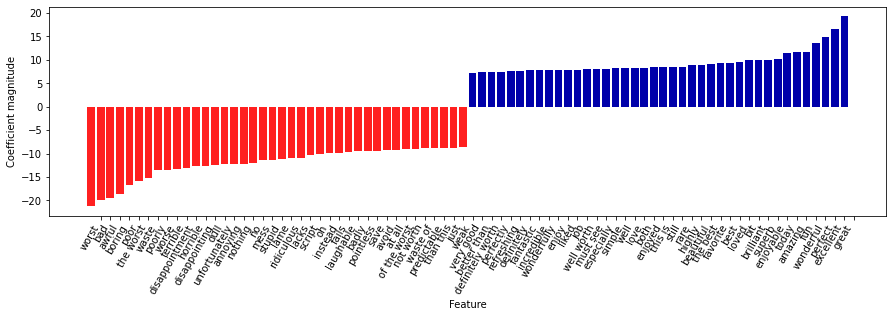

In [23]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())

coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

Podemos ver agora várias expressões que não apareciam no modelo unigram, como "worth", por exemplo. Já aqui temos "not worth" como negativo e "well worth" como positivo. Exemplo claro que o contexto ajuda muito em alguns casos. 

## Tokenização Avançada, Stemming e Lemmatization

Como dito anteriormente, o bag-of-words é relativamente simples e a tokenização utilizada também. Isso acarreta em features extras não necessárias, como o exemplo dos plurais dados logo no início do capítulo. Generalizar os tokens para que não exista múltiplos tokens para apanhar cada plural, forma verbal etc. resulta num modelo que generaliza melhor para datasets ainda não vistos.
<br>

Stemming e Lemmatization são duas formas de fazer a normalização das palavras, isto é, transformar as palavras em sua forma "normal". Stemming é um processo mais simples, em que são dropados sufixos comuns. Já o Lemmatizatization é um pouco mais complexo e toma o contexto da palavra além de usar um dicionário verificado.
<br>

Vamos implementa-los e verificar os resultados:

In [24]:
import spacy
import nltk

# dar load nos modelos em inglês do spacy
en_nlp = spacy.load('en_core_web_sm')

# função comparadaora
def compare_normalization(doc):
    doc_spacy = en_nlp(doc)
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    
    # instanciar o  stem
    stemmer = nltk.stem.PorterStemmer()
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])
    
compare_normalization(u"Our meeting today was worse than yesterday, "
                      "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


Note que o Stemming fica preso em cortar as palavras e para "was", ele retorna "wa". Já o Lemmatization transforma a palavra em um "be", retornando o verbo base da maneira correta. Podemos ver isso acontecendo no "meeting" e no "worse" também. No geral, os resultados do lemmazation são melhores para Machine Learning que o Stemming, mas é um processo um pouco mais complexo e que deve ser usado com maior atenção.

## Topic Modelling e Cluster de Documentos

Topic Modelling nada mais é que utilizar técnicas de clusterização não-supervisionada para definir o assunto de um grupo de documentos. Esse tipo de tarefa pode ser utilizada em posts de sites de notícias, tweets políticos etc.
<br>

Uma das técnicas mais comums é a **LDA** (Latent Dirichlet Allocation) e, de forma bem simples, ela tenta achar grupos de palavras (os tópicos) que aparecem juntos frequentemente. Vale notar que os resultados não são tópicos prontos, uma vez que a decomposição é não-supervisionada e é necessário utilizar conhecimento humano para complementar. Um tópico de política, por exemplo, pode ter palavras como governador, partido, voto etc. 
<br>

Vamos aplicar o LDA no dataset do IMDb que viemos utilizando até agora para ver como ele funciona na prática! Vamors remover as palavras comuns dos documentos, uma vez que em uma task como essa elas podem acabar dominando a análise:

In [27]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

from sklearn.decomposition import LatentDirichletAllocation

# vamos separar em 10 tópicos

lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(X)

Assim como o outros métodos de decomposição, como o PCA, o LDA tem um atributo `.components_` que armazena o quão importante cada palavra é para cada tópico. Vamos utilizá-lo para printar os tópicos com as palavras mais importantes:

In [28]:
# Para cada tópico (uma linha no components_), sort as features (ascending)
# Inverter as linhas com [:, ::-1] para fazer o sort descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

Podemos identificar algumas coisinhas por aqui. O tópico 1 claramente trata de filmes de guerra e documentários históricos, já o 2 de comédias ruins e o 3 de séries. 

Vamos ver os resultados caso a gente utilizasse 100 tópicos diferentes:

In [29]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)

document_topics100 = lda100.fit_transform(X)

# Apenas tópicos recomendados pelos autores (100 tópicos são demais)
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     performance   excellent     
suspense      awful         hitler        gets          young         role          highly        
horror        boring        nazi          guy           old           actor         amazing       
atmosphere    horrible      midnight      around        romantic      cast          wonderful     
mystery       stupid        joe           down          between       play          truly         
house         thing         germany       kill          romance       actors        superb        
director      terrible      years         goes          wonderful     performances  actors        
quite         script        history       killed        heart         played        brilliant     
bit       

Os tópicos extraídos utilizando o LDA agora são mais específicos, mas mais difíceis de interpretar. O tópico 7 parece ser sobre filmes de terror, enquanto o 16 e o 54 são sobre reviews negativas. O tópico 24 parece se tratar de filmes sobre o nazismo, mas tem até um Spock ali no meio hehe.

Podemos checar quais as reviews foram alocadas ao tópico utilizando um loop simples:

In [30]:
music = np.argsort(document_topics100[:, 45])[::-1]

for i in music[:10]:
    # mostrar apenas as 2 primeiras frases
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

## Sumário e Conclusão

O capítulo 7 introduziu o conceito de NLP e processamento de texto de forma bem básica, com um exemplo tradicional de aplicação em reviews do IMDb. Particularmente, eu tenho um baita interesse nessa área e nem tudo foi novidade, mas foi muito massa aplicar na prática como foi feito nesse capítulo. Além disso, o LDA foi uma surpresa muito bem vinda! Tenho certeza que usarei ele muito ainda. 

## Referência

**An Introduction to Machine Learning with Python** by Andreas C. Müller and Sarah Guido (O’Reilly), cap. 7. Copyright 2017 Sarah Guido and Andreas Müller, 978-1-449-36941-5.